<a href="https://colab.research.google.com/github/reifeitan/Hello_World/blob/master-branch/fraudEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Reading the dataset

In [29]:
df = pd.read_csv('financialdataset.csv')
print(df.shape)
print(df.isnull().sum())
print(df.head(3))

(6362620, 11)
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
   step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT  9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0               0
1     1   PAYMENT  1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0               0
2     1  TRANSFER   181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1               0


The power of pandas is reflected when using crosstab

In [30]:
dfpie = pd.crosstab(df.type, df.isFraud, margins=True, margins_name='Total', normalize='columns')
dfpie.rename(columns={0 : 'Genuine', 1 : 'Fraud'},inplace=True)
dfpie

isFraud,Genuine,Fraud,Total
type,,,
CASH_IN,0.220207,0.000000,0.219923
CASH_OUT,0.351470,0.501157,0.351663
DEBIT,0.006520,0.000000,0.006512
PAYMENT,0.338583,0.000000,0.338146
TRANSFER,0.083220,0.498843,0.083756


Let's visualize it with pie charts

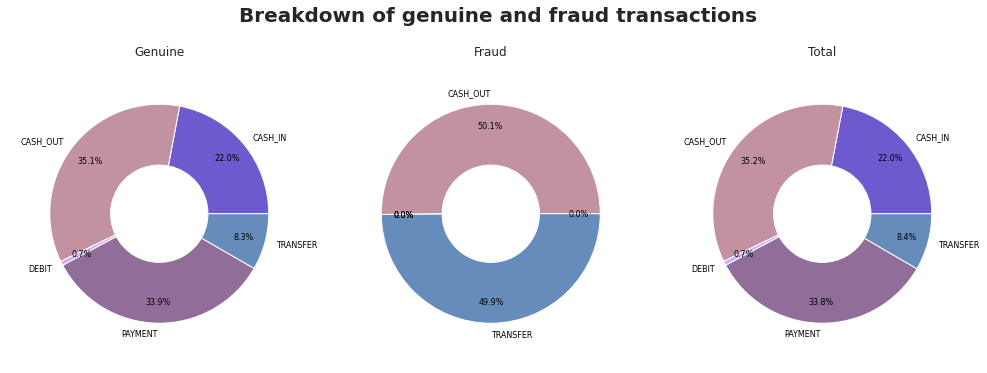

In [31]:
colors = ['xkcd:light indigo', 'xkcd:light mauve', 'xkcd:pale violet', 'xkcd:faded purple', 'xkcd:faded blue']
dfpie.plot(kind='pie', subplots=True, ylabel="", figsize=(14,6),colors=colors, legend=False, wedgeprops=dict(width=0.5), autopct="%.1f%%",
           pctdistance=0.8, labeldistance=1.1, radius=.9, textprops={'fontsize':8, 'color':'black'}, title=['Genuine', 'Fraud', 'Total'])


plt.suptitle('Breakdown of genuine and fraud transactions', size=20, weight='bold', ha='center')
plt.tight_layout()

plt.show()

Checking for the average amount of each transaction type by genuine/fraud, and visualizing it.

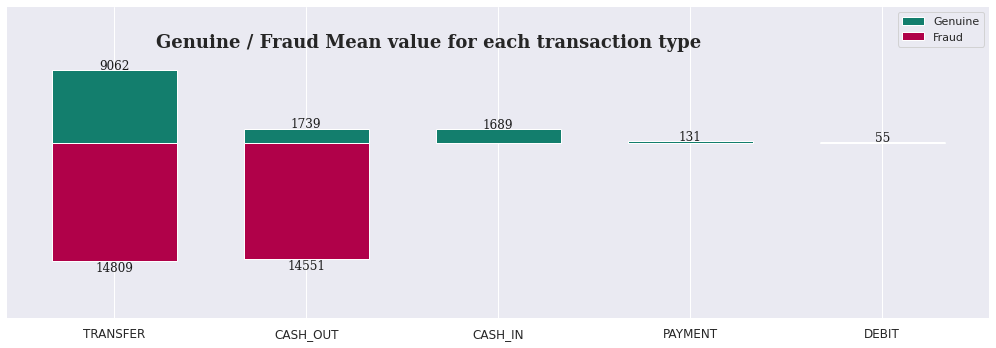

In [32]:
dfbar =pd.crosstab(df.type, df.isFraud, values=df.amount, aggfunc='mean')
dfbar.rename(columns={0 : 'Genuine', 1 : 'Fraud'}, inplace=True)
dfbar.sort_values('Genuine', inplace=True, ascending=False)
dfbar.fillna(value=0, inplace=True)


Genuine = round(dfbar['Genuine']/100).astype('int')
Fraud = round(-dfbar['Fraud']/100).astype('int')

fig, ax = plt.subplots(1,1, figsize=(14,5))
ax.bar(dfbar.index, Genuine, width=0.65, color='xkcd:blue green', label='Genuine')
ax.bar(dfbar.index, Fraud, width=0.65, color='xkcd:raspberry', label='Fraud')
ax.set_ylim(-22000,17000)

for i in dfbar.index:
    ax.annotate(f"{Genuine[i]}",
                   xy=(i, Genuine[i] + 520),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='k')


for i in dfbar.index:
    if Fraud[i] == 0:
        continue
    else:
         ax.annotate(f"{-Fraud[i]}",
                   xy=(i, Fraud[i] - 870),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='k')


for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)


ax.tick_params(axis='x', labelsize=12)
ax.set_yticks([])
ax.legend()
fig.text(0.16, 0.85, 'Genuine / Fraud Mean value for each transaction type', fontsize=18, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()

I wanted to try and see if clustering can help me dig deeper. <br>
Here KMeans, and once I'm done exploring I'll check another clustering algo.

I did some work for the features handling that later realized wasn't really needed, but it might help me with the exploration.

In [55]:
# Features handling

# Names - Customers and Merchants
dfml = df.copy()
maskc1 = dfml['nameOrig'].str.startswith('C')
maskm1 = dfml['nameOrig'].str.startswith('M')
dfml.loc[maskc1, 'nameOrig'] = 0
dfml.loc[maskm1, 'nameOrig'] = 1
maskc2 = dfml['nameDest'].str.startswith('C')
maskm2 = dfml['nameDest'].str.startswith('M')
dfml.loc[maskc2, 'nameDest'] = 0
dfml.loc[maskm2, 'nameDest'] = 1


# Step - creating days and hours.
dfml['day'] = dfml['step'].map(lambda t: t//24 + 1)
dfml['hour'] = dfml['step'].map(lambda t: t%24)
dfclusters = dfml.copy()
# type
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dfml['type1'] = le.fit_transform(dfml['type'])

dfml.drop(['step', 'type', 'isFlaggedFraud','nameOrig','oldbalanceOrg','newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'day', 'hour'], axis=1, inplace=True)


I will check different numbers of clusters and see what works best <br>
I used the "elbow point" - not very emprical I know, however it shows where lays the reasonable trade-off between error and number of clusters. <br>
In our case the sweetspot seems the be 3-5 clusters. so I picked 4. <br>
It ran for ages, so no chart is added.

In [ ]:
## KMeans

from sklearn.cluster import KMeans
from collections import Counter

kmeans_kwargs = { 'init':'random',  'n_init' : 10, 'max_iter' :300, 'random_state':42}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dfml)
    sse.append(kmeans.inertia_)

labels = kmeans.labels_

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

I'll take it from here with 4 clusters as explained above.

In [57]:
from sklearn.cluster import KMeans
from collections import Counter
kmeans = KMeans(init='random',  n_init= 10, max_iter=300, random_state=42, n_clusters=4)
kmeans.fit(dfml)
predict = kmeans.predict(dfml)
labels = kmeans.labels_
print(Counter(labels))
dfml['label'] = predict

Counter({1: 5487616, 0: 816274, 2: 51572, 3: 7158})


Adding the labels of the clusters to a df for visualizing.

In [ ]:
dfclusters = dfclusters.merge(dfml, left_index=True, right_index=True)
dfclusters.head(1)

In [ ]:
dfclusters.drop(['amount_y', 'isFraud_y', 'type1'], axis=1, inplace=True)
crosstab = pd.crosstab(dfclusters.label, dfclusters.isFraud_x, normalize='index', margins_name='All', margins=True)
crosstab.rename(columns={0 : 'Genuine', 1 : 'Fraud'},inplace=True)


In [60]:
crosstab

isFraud_x,Genuine,Fraud
label,,
0,0.996509,0.003491
1,0.999367,0.000633
2,0.971360,0.028640
3,0.942163,0.057837
All,0.998709,0.001291


Didn't want to have 'Cluster 0' so added 1 to each cluster number.

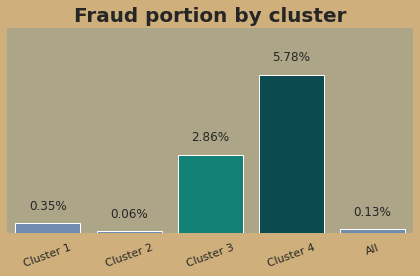

In [39]:
sns.set(rc={'axes.facecolor':'xkcd:stone', 'figure.facecolor':'xkcd:fawn'})
colors = ['xkcd:faded blue', 'xkcd:faded blue', 'xkcd:teal', 'xkcd:deep teal', 'xkcd:faded blue']
ax = sns.barplot(x=crosstab.index, y=(crosstab.Fraud), palette=colors)
ax.set_xticklabels(['Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'All' ], rotation=20, ha='center')
ax.set_yticklabels("")
ax.set_ylim(0,.075)
ax.grid(False)
sns.despine(left=True,bottom=True)
plt.title('Fraud portion by cluster',size=20, weight='bold')
plt.xlabel("")
plt.ylabel('')

for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2), y= height+0.005, s='{:.2%}'.format(height), ha ='center')

plt.tight_layout()
plt.show()

It looks interesting. I'll keep exploring and updating this notebook later this week.